In [ ]:
!pip -q install --upgrade torch torchaudio --index-url https://download.pytorch.org/whl/cu121

import torch, torchaudio
print(torch.__version__, torchaudio.__version__)

2.8.0+cu126 2.8.0+cu126


In [ ]:
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchaudio
from torchaudio import transforms as T

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import shutil, os

# ===== Parámetros mínimos =====
#hollllaa
#funcionna???
SEED = 42
DATA_ROOT = Path('/content/data/speech_commands')
DATA_ROOT.mkdir(parents=True, exist_ok=True)

CLASSES = ['yes','no','up','down','left','right','on','off','stop','go']
NATIVE_SR = 16000
N_FFT = 256
HOP_LENGTH = 160
N_MELS = 32

BATCH_SIZE = 128
EPOCHS = 100
LR = 1e-3

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
if DEVICE == 'cuda': torch.cuda.manual_seed_all(SEED)

print("Device:", DEVICE)
print("Datos en:", DATA_ROOT.resolve())


Device: cuda
Datos en: /content/data/speech_commands


In [ ]:
def _lists_exist(root: Path) -> bool:
    base = root / "SpeechCommands" / "speech_commands_v0.02"
    return (base / "validation_list.txt").exists() and (base / "testing_list.txt").exists()

def _bootstrap_download(root: Path):
    """Descarga completa (con subset=None) para garantizar que existan las listas oficiales."""
    # limpiar descargas incompletas
    shutil.rmtree(root / "SpeechCommands", ignore_errors=True)
    _ = torchaudio.datasets.SPEECHCOMMANDS(root=str(root), download=True, subset=None)
    if not _lists_exist(root):
        raise RuntimeError("No se pudieron crear las listas oficiales tras la descarga.")

class MiniSpeechCommandsRaw(Dataset):
    """
    - Intenta usar/download el split pedido.
    - Si detecta dataset incompleto, se auto-repara (bootstrap con subset=None) y reintenta.
    - Devuelve (waveform_crudo, sr, label_id) sin preprocesar.
    """
    def __init__(self, root, classes, subset='training'):
        root = Path(root)
        root.mkdir(parents=True, exist_ok=True)

        try:
            # Intento normal: si ya está en /content, no vuelve a bajar
            base = torchaudio.datasets.SPEECHCOMMANDS(
                root=str(root), download=True, subset=subset
            )
            # Algunas veces torchaudio no tira excepción, pero las listas faltan:
            if not _lists_exist(root):
                raise FileNotFoundError("List files missing after download.")
        except FileNotFoundError:
            # Auto-reparación: descarga completa y reintento sin download
            _bootstrap_download(root)
            base = torchaudio.datasets.SPEECHCOMMANDS(
                root=str(root), download=False, subset=subset
            )

        self.classes = list(classes)
        c2i = {c: i for i, c in enumerate(self.classes)}
        self.items = []
        for i in tqdm(range(len(base)), desc=f"Cargando/filtrando '{subset}'", unit="audio"):
            wav, sr, label, *_ = base[i]
            if label in c2i:
                self.items.append((wav, sr, c2i[label]))

        if not self.items:
            raise RuntimeError(f"Sin ejemplos para {self.classes} en subset={subset}.")

    def __len__(self): return len(self.items)
    def __getitem__(self, idx): return self.items[idx]



In [ ]:
train_ds = MiniSpeechCommandsRaw(DATA_ROOT, CLASSES, subset='training')
val_ds   = MiniSpeechCommandsRaw(DATA_ROOT, CLASSES, subset='validation')
test_ds  = MiniSpeechCommandsRaw(DATA_ROOT, CLASSES, subset='testing')

print(f"Tamaños -> train: {len(train_ds)} | val: {len(val_ds)} | test: {len(test_ds)}")


100%|██████████| 2.26G/2.26G [01:43<00:00, 23.5MB/s]
Cargando/filtrando 'training':   0%|          | 0/84843 [00:00<?, ?audio/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video ar

Tamaños -> train: 30769 | val: 3703 | test: 4074


Clase: right | sr: 16000 | shape: (1, 16000) | dur: 1.00s


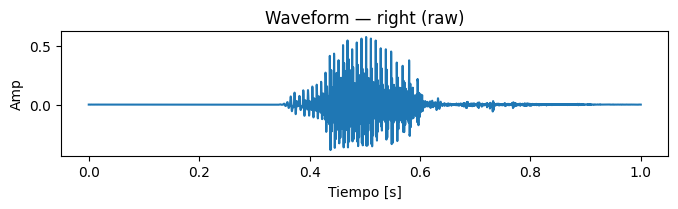

Clase: go | sr: 16000 | shape: (1, 16000) | dur: 1.00s


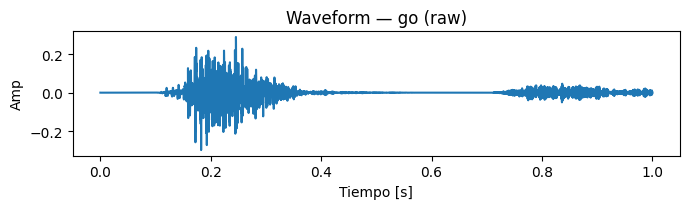

In [ ]:
def plot_waveform(wav, sr, title="Waveform (raw)"):
    x = wav.squeeze().cpu().numpy()
    t = np.arange(len(x))/sr
    plt.figure(figsize=(7, 2.2))
    plt.plot(t, x)
    plt.xlabel("Tiempo [s]"); plt.ylabel("Amp"); plt.title(title)
    plt.tight_layout(); plt.show()

for _ in range(2):
    idx = random.randrange(len(train_ds))
    wav, sr, y = train_ds[idx]
    print(f"Clase: {CLASSES[y]} | sr: {sr} | shape: {tuple(wav.shape)} | dur: {wav.shape[-1]/sr:.2f}s")
    plot_waveform(wav, sr, title=f"Waveform — {CLASSES[y]} (raw)")


Ejemplo idx=23654 | clase=stop | sr=16000 | dur=1.00s


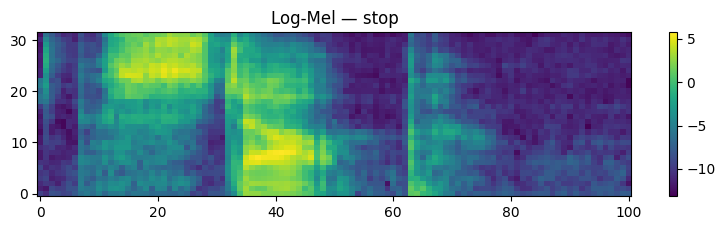

▶️ Reproducir:


In [ ]:
from IPython.display import Audio, display

mel_tf_vis = T.MelSpectrogram(sample_rate=NATIVE_SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
#blogpost sobre MEL (https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53)

def plot_logmel(wav, sr, title="Log-Mel"):
    with torch.no_grad():
        # wav: (1, T) o (T,) -> Mel mantiene canal si hay (1,T)
        M = mel_tf_vis(wav)                     # (1, F, Tm) o (F, Tm)
        LM = torch.log(M + 1e-6)
        if LM.ndim == 3 and LM.shape[0] == 1:   # quitar canal
            LM = LM.squeeze(0)                  # (F, Tm)
        elif LM.ndim == 1:                      # por si viniera (Tm,)
            LM = LM.unsqueeze(0)
        LM = LM.cpu().numpy()

    plt.figure(figsize=(8, 2.4))
    plt.imshow(LM, aspect='auto', origin='lower')
    plt.title(title); plt.colorbar(); plt.tight_layout(); plt.show()

def play_audio(wav, sr):
    x = wav.squeeze().cpu().numpy()
    display(Audio(x, rate=sr))

idx = np.random.randint(len(train_ds))
wav, sr, y = train_ds[idx]
print(f"Ejemplo idx={idx} | clase={CLASSES[y]} | sr={sr} | dur={wav.shape[-1]/sr:.2f}s")
plot_logmel(wav, sr, title=f"Log-Mel — {CLASSES[y]}")
print("▶️ Reproducir:")
play_audio(wav, sr)


In [ ]:
def collate_wave_flat(batch):
    """
    batch: lista de (wav_crudo, sr, y) con longitudes variables.
    1) pad por batch a la longitud máxima del batch
    2) aplanar a (B, Tmax) para MLP
    """
    max_len = max(wav.shape[-1] for wav, _, _ in batch)
    padded, ys = [], []
    for wav, sr, y in batch:
        pad_len = max_len - wav.shape[-1]
        if pad_len > 0:
            wav = F.pad(wav, (0, pad_len))   # (1, Tmax)
        padded.append(wav)
        ys.append(y)
    W = torch.stack(padded, dim=0)          # (B, 1, Tmax)
    X = W.flatten(1)                        # (B, Tmax)  <- waveform crudo aplanado
    y = torch.tensor(ys, dtype=torch.long)
    return X, y

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, collate_fn=collate_wave_flat)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_wave_flat)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_wave_flat)

# Dimensión de entrada para el MLP
xb, yb = next(iter(train_loader))
in_features = xb.shape[1]
num_classes = len(CLASSES)
print("in_features:", in_features, "| num_classes:", num_classes)

in_features: 16000 | num_classes: 10


In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(in_features, num_classes).to(DEVICE)
opt = torch.optim.SGD(model.parameters(), lr=LR)
crit = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(1, EPOCHS+1):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        logits = model(X)
        loss = crit(logits, y)
        loss.backward()
        opt.step()

        loss_sum += loss.item()*y.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    print(f"Epoch {epoch:02d} | loss={loss_sum/total:.3f} | acc={correct/total:.3f}")

Epoch 01 | loss=2.304 | acc=0.103
Epoch 02 | loss=2.304 | acc=0.103
Epoch 03 | loss=2.304 | acc=0.103
Epoch 04 | loss=2.303 | acc=0.103
Epoch 05 | loss=2.303 | acc=0.104
Epoch 06 | loss=2.303 | acc=0.104
Epoch 07 | loss=2.303 | acc=0.104
Epoch 08 | loss=2.302 | acc=0.105
Epoch 09 | loss=2.302 | acc=0.105
Epoch 10 | loss=2.302 | acc=0.106
Epoch 11 | loss=2.302 | acc=0.106
Epoch 12 | loss=2.301 | acc=0.106
Epoch 13 | loss=2.301 | acc=0.107
Epoch 14 | loss=2.301 | acc=0.107
Epoch 15 | loss=2.301 | acc=0.108
Epoch 16 | loss=2.300 | acc=0.108
Epoch 17 | loss=2.300 | acc=0.109
Epoch 18 | loss=2.300 | acc=0.109
Epoch 19 | loss=2.300 | acc=0.110
Epoch 20 | loss=2.300 | acc=0.110
Epoch 21 | loss=2.299 | acc=0.111
Epoch 22 | loss=2.299 | acc=0.112
Epoch 23 | loss=2.299 | acc=0.113
Epoch 24 | loss=2.299 | acc=0.114
Epoch 25 | loss=2.299 | acc=0.115
Epoch 26 | loss=2.299 | acc=0.116
Epoch 27 | loss=2.298 | acc=0.117
Epoch 28 | loss=2.298 | acc=0.119
Epoch 29 | loss=2.298 | acc=0.120
Epoch 30 | los

In [ ]:
model.eval()
with torch.no_grad():
    X, y = next(iter(val_loader))
    pred = model(X.to(DEVICE)).argmax(1).cpu().numpy()
    print("Predicciones (primeros 20):", [CLASSES[i] for i in pred[:20]])
